In [92]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


In [93]:
#Load the Dataset
dataset = pd.read_csv('dataset.csv')

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


In [94]:
# Data summary
data_summary = {
    "Total Rows": dataset.shape[0],
    "Total Columns": dataset.shape[1],
    "Column Types": dataset.dtypes.value_counts().to_dict()
}

# Missing values analysis
missing_values = dataset.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]  # Only show columns with missing values

# Statistical summary for numerical features
statistical_summary = dataset.describe()

data_summary, missing_values.head(10), statistical_summary


({'Total Rows': 100000,
  'Total Columns': 82,
  'Column Types': {dtype('int64'): 68, dtype('float64'): 8, dtype('O'): 6}},
 SURVEY_AVG_NPS_SCORE          99635
 SURVEY_AVG_CXI_SCORE          98810
 SURVEY_AVG_CASE_MOOD_SCORE    97556
 DNB_GLOBAL_SALES_REVENUE      38137
 DNB_GLOBAL_EMPLOYEE_COUNT     38137
 SECTOR                        15070
 dtype: int64,
        TENURE_MONTHS  DNB_GLOBAL_SALES_REVENUE  DNB_GLOBAL_EMPLOYEE_COUNT  \
 count  100000.000000              6.186300e+04               6.186300e+04   
 mean       43.069110              3.049351e+09               7.569068e+03   
 std        33.474739              2.298173e+10               7.891647e+04   
 min        -1.000000              1.000000e+00               2.000000e+00   
 25%        21.000000              1.285110e+07               7.900000e+01   
 50%        35.000000              5.596105e+07               2.600000e+02   
 75%        52.000000              2.812486e+08               1.092000e+03   
 max       191.

# Initial Obeservations
## Top 5 Columns with Missing Values:
1. **SURVEY_AVG_NPS_SCORE**: 99,635 missing
2. **SURVEY_AVG_CXI_SCORE**: 98,810 missing
3. **SURVEY_AVG_CASE_MOOD_SCORE**: 97,556 missing
4. **DNB_GLOBAL_SALES_REVENUE**: 38,137 missing
5. **DNB_GLOBAL_EMPLOYEE_COUNT**: 38,137 missing

## Statistical Summary (Key Points)
- **TENURE_MONTHS**: Varies widely, with a minimum of -1 (which might be an error) and a maximum of 191 months.
- **CHURN**: The target variable, with only 0.67% churned customers, indicating a highly imbalanced dataset.

## Imbalanced Dataset
- **Low churn rate**: Suggests class(categories) are not represented equally. This Needs addressing during model training.

## Missing Data
- **High levels of missing data**: Particularly in survey-related scores, requiring careful handling.

## Potential Data Issues
- **Negative values in TENURE_MONTHS and CONTRACT_LENGTH**: May indicate data entry errors.

## Diverse Feature Set
- **Mix of customer profile, usage, and engagement data**: Will help with the churn prediction.



## Next Steps

1. **Data Cleaning**: Address missing values, incorrect data entries, and potential outliers.
2. **Exploratory Data Analysis (EDA)**: Conduct deeper EDA to understand the relationship between individual features and the target variable.
3. **Feature Engineering**: Create new features that could be more predictive of churn.


# Data Cleaning

In [95]:
from sklearn.impute import SimpleImputer
import numpy as np

# Handling missing values
# Inputting missing values for DNB_GLOBAL_SALES_REVENUE and DNB_GLOBAL_EMPLOYEE_COUNT with median
median_imputer = SimpleImputer(strategy='median')
dataset['DNB_GLOBAL_SALES_REVENUE'] = median_imputer.fit_transform(dataset[['DNB_GLOBAL_SALES_REVENUE']])
dataset['DNB_GLOBAL_EMPLOYEE_COUNT'] = median_imputer.fit_transform(dataset[['DNB_GLOBAL_EMPLOYEE_COUNT']])

# For survey scores with a high percentage of missing values, we'll impute with a default value indicating no response
# This approach retains the information that these surveys were not filled
dataset['SURVEY_AVG_NPS_SCORE'].fillna(-1, inplace=True)
dataset['SURVEY_AVG_CXI_SCORE'].fillna(-1, inplace=True)
dataset['SURVEY_AVG_CASE_MOOD_SCORE'].fillna(-1, inplace=True)

# Correcting data inconsistencies
# Fixing negative values in TENURE_MONTHS and CONTRACT_LENGTH by replacing them with NaN and then replacing those NaN values with the median_inputer.
dataset['TENURE_MONTHS'] = dataset['TENURE_MONTHS'].apply(lambda x: np.nan if x < 0 else x) # for ever x value less than 0 replace with NaN
dataset['CONTRACT_LENGTH'] = dataset['CONTRACT_LENGTH'].apply(lambda x: np.nan if x < 0 else x) # for ever x value less than 0 replace with NaN
dataset['TENURE_MONTHS'] = median_imputer.fit_transform(dataset[['TENURE_MONTHS']])
dataset['CONTRACT_LENGTH'] = median_imputer.fit_transform(dataset[['CONTRACT_LENGTH']])

# Convert date columns to datetime format
dataset['ACCOUNTING_MONTH'] = pd.to_datetime(dataset['ACCOUNTING_MONTH'])
dataset['RENEWAL_MONTH'] = pd.to_datetime(dataset['RENEWAL_MONTH'], utc=True)
dataset['CONTRACT_START_DATE'] = pd.to_datetime(dataset['CONTRACT_START_DATE'], utc=True)

# Check the dataset after these operations
dataset.head()


,SALESFORCEACCOUNTID,ACCOUNTING_MONTH,RENEWAL_MONTH,CONTRACT_START_DATE,REGION,SECTOR,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,...,SUM_HIGH_CASES,SUM_MEDIUM_CASES,SUM_LOW_CASES,SUM_STANDARD_CASES,SUPPORT_CASE_NUMBEROFSLABREACHES,BACKLOG,SURVEY_AVG_CXI_SCORE,SURVEY_AVG_NPS_SCORE,SURVEY_AVG_CASE_MOOD_SCORE,CHURN
0,0011N00001hBZM7QAO,2021-10-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2020-12-24 00:00:00+00:00,UKI,Professional Services,126.0,55961051.0,260.0,364.0,...,0,0,0,0,0,1,-1.0,-1.0,-1.0,0
1,0011N00001hBZM7QAO,2021-11-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2020-12-24 00:00:00+00:00,UKI,Professional Services,127.0,55961051.0,260.0,364.0,...,0,0,0,0,0,1,-1.0,-1.0,-1.0,0
2,0011N00001hBZM7QAO,2021-12-01 00:00:00+00:00,2022-12-01 00:00:00+00:00,2021-12-24 00:00:00+00:00,UKI,Professional Services,128.0,55961051.0,260.0,364.0,...,0,0,0,0,0,1,-1.0,-1.0,-1.0,0
3,0011N00001hBZM7QAO,2022-01-01 00:00:00+00:00,2022-12-01 00:00:00+00:00,2021-12-24 00:00:00+00:00,UKI,Professional Services,129.0,55961051.0,260.0,364.0,...,0,0,0,0,0,1,-1.0,-1.0,-1.0,0
4,0011N00001hBZM7QAO,2022-02-01 00:00:00+00:00,2022-12-01 00:00:00+00:00,2021-12-24 00:00:00+00:00,UKI,Professional Services,130.0,55961051.0,260.0,364.0,...,0,0,0,0,0,1,-1.0,-1.0,-1.0,0


## Handling Missing Values

- **High Percentage Missing Values**: 
  - Columns like survey scores with a high percentage of missing values need a decision on whether to impute, drop, or transform.
- **Low Percentage Missing Values**:
  - For columns with fewer missing values, consider imputation using mean, median, or mode. Could potentially use a more sophisticated method like k-NN imputation (however for this we will use our basic statistics for missing vlaues).
- **Specific Replacement Strategies**:
    - `DNB_GLOBAL_SALES_REVENUE` and `DNB_GLOBAL_EMPLOYEE_COUNT` have missing data were replaced using median values.
  - **Survey Scores**:
    - `SURVEY_AVG_NPS_SCORE`, `SURVEY_AVG_CXI_SCORE`, `SURVEY_AVG_CASE_MOOD_SCORE` all have High missing values replaced with a default value of -1, indicating no response.

## Correcting Data Inconsistencies

- **Negative Values**:
  - Address negative values in `TENURE_MONTHS` and `CONTRACT_LENGTH`.
- **Date Columns**:
  - Convert date columns to datetime format and extract information such as month and year.


## Outlier Detection and Handling

- **Identification**:
  - Identify outliers in numerical columns.
- **Handling Strategy**:
  - Decide on a strategy for handling outliers, such as capping or transformation.
  - Specific columns like `ACCOUNTING_MONTH`, `RENEWAL_MONTH`, and `CONTRACT_START_DATE` were converted to datetime format for better handling and feature engineering.


# Feature Engineering

In [96]:
# Feature Engineering
# 1. Temporal Features
dataset['MONTHS_TO_RENEWAL'] = (dataset['RENEWAL_MONTH'] - dataset['ACCOUNTING_MONTH']).dt.days / 30
dataset['CONTRACT_AGE'] = (dataset['ACCOUNTING_MONTH'] - dataset['CONTRACT_START_DATE']).dt.days / 30

# 2. Aggregated and Interaction Features
# Interaction between ARR and SEATS
dataset['ARR_SEATS_INTERACTION'] = dataset['ARR'] * dataset['SEATS']

# 3. Categorical Encoding
# One-hot encoding for categorical variables like REGION and SECTOR
# Note: Depending on the number of unique values, we might need to handle high cardinality differently
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
categorical_columns = ['REGION', 'SECTOR']
encoded_categorical = onehot_encoder.fit_transform(dataset[categorical_columns])

# Creating a DataFrame from the encoded categorical data
encoded_categorical_df = pd.DataFrame(encoded_categorical, 
                                      columns=onehot_encoder.get_feature_names_out(categorical_columns))

# Concatenating the encoded categorical data with the original DataFrame
dataset = pd.concat([dataset, encoded_categorical_df], axis=1)

# Dropping the original categorical columns
dataset.drop(categorical_columns, axis=1, inplace=True)

# Check the dataset after these operations
dataset.head()

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,SALESFORCEACCOUNTID,ACCOUNTING_MONTH,RENEWAL_MONTH,CONTRACT_START_DATE,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,...,SECTOR_Not For Profit,SECTOR_Other,SECTOR_Professional Services,SECTOR_Real Estate,SECTOR_Retail & Wholesale,SECTOR_Sci/Tech,SECTOR_Telecommunications,"SECTOR_Transportation, Storage & Delivery","SECTOR_Travel, Hospitality & Catering",SECTOR_nan
0,0011N00001hBZM7QAO,2021-10-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2020-12-24 00:00:00+00:00,126.0,55961051.0,260.0,364.0,27241.17,330,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0011N00001hBZM7QAO,2021-11-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2020-12-24 00:00:00+00:00,127.0,55961051.0,260.0,364.0,27241.17,330,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0011N00001hBZM7QAO,2021-12-01 00:00:00+00:00,2022-12-01 00:00:00+00:00,2021-12-24 00:00:00+00:00,128.0,55961051.0,260.0,364.0,30349.76,350,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0011N00001hBZM7QAO,2022-01-01 00:00:00+00:00,2022-12-01 00:00:00+00:00,2021-12-24 00:00:00+00:00,129.0,55961051.0,260.0,364.0,30349.76,350,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0011N00001hBZM7QAO,2022-02-01 00:00:00+00:00,2022-12-01 00:00:00+00:00,2021-12-24 00:00:00+00:00,130.0,55961051.0,260.0,364.0,30349.76,350,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Engineering Steps

**Temporal Features**
- Derive features from date columns, such as the time until renewal or contract age.
- In this case `MONTHS_TO_RENEWAL` = (`RENEWAL MONTH` - `ACCOUNTING MONTH`)/30 (We convert to days prior to /30)
- `CONTRACT_AGE` = `ACCOUNTING_MONTH` - `CONTRACT_START_DATE`

**Aggregated Features & Interaction Features**
- Create aggregated features (e.g., average ARR (annual reccuring revenue) over the past few months) that might capture trends in customer behavior.
- Create interaction terms between features that might jointly have a predictive value (e.g., ARR * SEATS).
- In this case `ARR_SEATS_INTERACTION` = `ARR` * `SEATS`

**Categorical Encoding**
- Convert categorical variables into a format suitable for modeling (e.g., one-hot encoding, label encoding).
- In this case `REGION` & `SECTOR`

Now the dataset includes a more comprehensive set of features that can be used to help predict customer churn.

# Exploratory Data Analysis (EDA)
This phase involves deeper analysis of the dataset to uncover insights and relationships between features and the target variable (CHURN). Key steps in this phase include:

- **Relationship Analysis**:
  - Analyze the relationships between newly created features and the target variable CHURN.
- **Visualization**:
  - Visualize key features to understand their distribution and impact on churn.



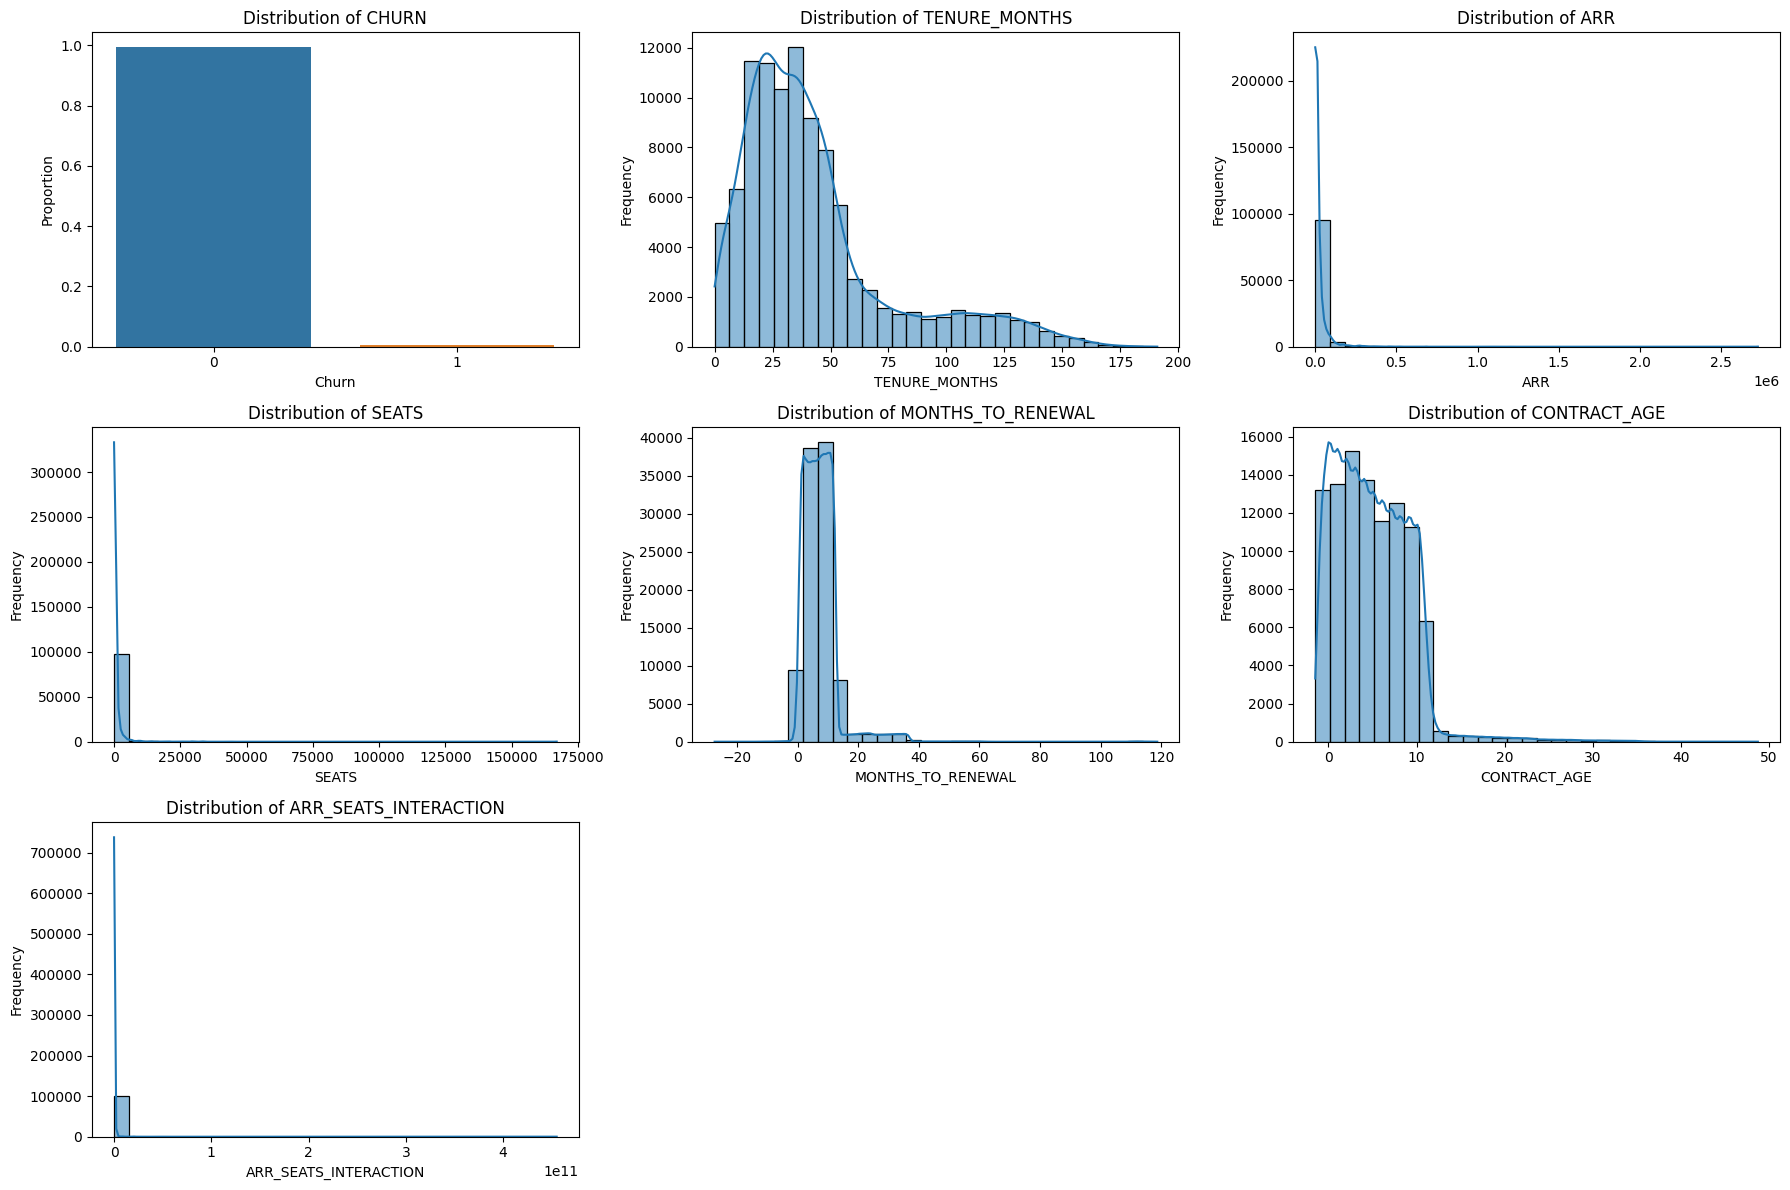

(CHURN                        1.000000
 CUSTOMER_BEHAVIOUR_FOUR      0.202693
 CONTRACT_AGE                 0.075905
 SEATS_DOWNSELL_RECENCY       0.035692
 DETECTEDSEATSCOUNT           0.021347
 CHURN_RISK_DISCUSSION        0.016781
 SECTOR_IT                    0.015083
 ACCOUNTMANAGER_CHANGE        0.013891
 CUSTOMER_BEHAVIOUR_NINE      0.013267
 REGION_RoE                   0.010273
 DNB_GLOBAL_EMPLOYEE_COUNT    0.010156
 Name: CHURN, dtype: float64,
 CONTRACT_START_DATE    -0.025517
 ARR                    -0.026272
 CONTRACT_LENGTH        -0.026712
 PRODUCT_FIVE           -0.032480
 PRODUCT_ONE            -0.033021
 RENEWAL_MONTH          -0.038675
 SEATS_UPSELL_RECENCY   -0.068108
 MONTHS_TO_RENEWAL      -0.085110
 PRODUCT_TWENTYONE            NaN
 PRODUCT_TWENTYTWO            NaN
 Name: CHURN, dtype: float64)

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# EDA: Target Variable Analysis
churn_distribution = dataset['CHURN'].value_counts(normalize=True)

# EDA: Feature Analysis - Selecting a few key features for analysis
key_features = ['TENURE_MONTHS', 'ARR', 'SEATS', 'MONTHS_TO_RENEWAL', 'CONTRACT_AGE', 'ARR_SEATS_INTERACTION']

# Plotting the distribution of the 'CHURN' variable and a few key features
plt.figure(figsize=(18, 12))

# Plot for target variable distribution
plt.subplot(3, 3, 1)
sns.barplot(x=churn_distribution.index, y=churn_distribution.values)
plt.title('Distribution of CHURN')
plt.xlabel('Churn')
plt.ylabel('Proportion')

# Plot for key features
for i, feature in enumerate(key_features, start=2):
    plt.subplot(3, 3, i)
    sns.histplot(dataset[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Drop the 'salesforceaccountid' column
dataset_without_accountid = dataset.drop('SALESFORCEACCOUNTID', axis=1)


# Correlation of features with CHURN
correlations = dataset_without_accountid.corr()['CHURN'].sort_values(ascending=False)

# Display top 10 positively and negatively correlated features
correlations_top_10_positive = correlations.head(11)  # Including CHURN itself
correlations_top_10_negative = correlations.tail(10)

correlations_top_10_positive, correlations_top_10_negative





- `MONTHS_TO_RENEWAL`: -0.085 correlation
- `CONTRACT_AGE`: 0.075905 correlation

## 1. Target Variable Analysis: CHURN
- **Class Imbalance**: Significant imbalance in the CHURN variable, a common issue in churn prediction.
- **Implication for Model Training**: Requires addressing to avoid model bias towards the majority class.

## 2. Key Feature Analysis
- **Tenure Months (TENURE_MONTHS)**: Indicates a range of customer relationships, from new to long-standing.
- **Annual Recurring Revenue (ARR)**: Wide range, suggesting diversity in customer size and revenue contribution.
- **Seats (SEATS)**: Variation in the number of seats per customer.
- **Months to Renewal (MONTHS_TO_RENEWAL)** and **Contract Age (CONTRACT_AGE)**: Potential importance in understanding customer churn related to the contract lifecycle.
- **ARR and Seats Interaction (ARR_SEATS_INTERACTION)**: Distribution of this interaction term may provide insights on its combined effects on churn.

## 3. Correlation Analysis
- **Top Negative Correlations**: Features like MONTHS_TO_RENEWAL and SEATS_UPSELL_RECENCY negatively correlate with CHURN, indicating factors like longer time to renewal and recent seat upsell activities might be linked with lower churn risk.
- **Top Positive Correlations**: Features such as CONTRACT_AGE and CUSTOMER_BEHAVIOUR_FOUR show positive correlations with churn, suggesting they might be risk factors.

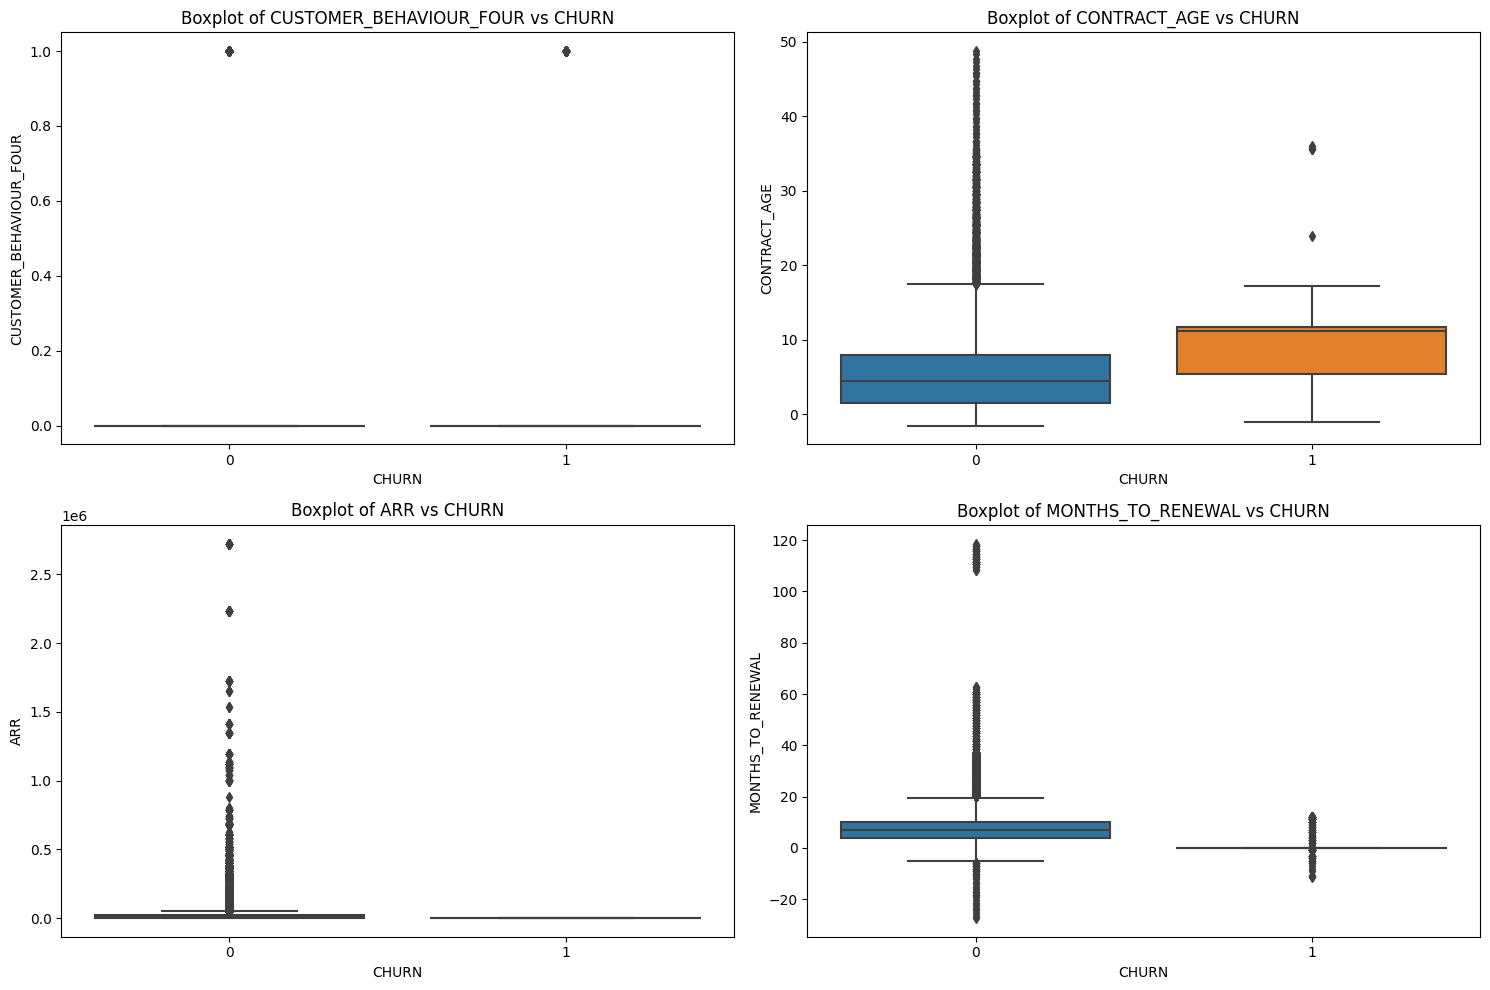

In [98]:
# Visualizing some key features against CHURN

# Selecting a few key features for visualization based on their correlations
features_to_visualize = ['CUSTOMER_BEHAVIOUR_FOUR', 'CONTRACT_AGE', 'ARR', 'MONTHS_TO_RENEWAL']

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

# Plotting each feature
for i, feature in enumerate(features_to_visualize):
    sns.boxplot(x='CHURN', y=feature, data=dataset, ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} vs CHURN')
    axes[i].set_ylabel(feature)
    axes[i].set_xlabel('CHURN')

plt.tight_layout()
plt.show()

# Visual Analysis Insights

The boxplots provide insights into how different key features vary with respect to the CHURN variable:

- **CUSTOMER_BEHAVIOUR_FOUR**:
  - There is a noticeable difference in the distribution of this feature between churned and non-churned customers, suggesting its potential importance in predicting churn.

- **CONTRACT_AGE**:
  - Churned customers appear to have a slightly different distribution in contract age compared to non-churned customers, indicating that the age of the contract could influence churn.

- **ARR (Annual Recurring Revenue)**:
  - The distribution of ARR shows some differences between the two groups, which might be useful for the model.

- **MONTHS_TO_RENEWAL**:
  - This feature exhibits variation between churned and non-churned customers, potentially indicating its relevance in predicting churn.


## Model Building
After completing the EDA, the next steps involve developing the predictive model:
- **Data Splitting**:
  - Split the dataset into training and testing sets.
- **Training and Evaluation**:
  - Train various machine learning models and evaluate their performance.
- **Model Fine-tuning and Selection**:
  - Fine-tune the models and select the best performing one for churn prediction.

## Data Splitting
- **Dividing the Dataset**: Split the dataset into training and testing sets to prepare for model training and evaluation.

## Model Training
- **Training Different Models**: Train various models and evaluate their initial performance to identify the most promising ones.

## Model Tuning
- **Optimizing Performance**: Adjust and optimize the models to improve their predictive capabilities.

## Model Evaluation
- **Using Informative Metrics**: Employ metrics like precision, recall, and F1-score, which are particularly relevant for imbalanced datasets to thoroughly assess model performance.

In [99]:
# Dropping non-numeric columns that are not useful for modeling (like identifiers)
# Also dropping the original date columns as they have been transformed into more useful features
# Features and target variable
X = dataset_without_accountid.drop('CHURN', axis=1)
y = dataset_without_accountid['CHURN']

columns_to_drop = ['ACCOUNTING_MONTH', 'RENEWAL_MONTH', 'CONTRACT_START_DATE']
X_cleaned = X.drop(columns=columns_to_drop)

# Retry data splitting and scaling
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Confirming the split
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape


((80000, 110), (20000, 110), (80000,), (20000,))

The data has been successfully split and scaled for model training:

- **Training Set Size**: 80,000 samples
- **Testing Set Size**: 20,000 samples
- **Number of Features**: 110

# Model Building
Next, we will train various machine learning models suitable for binary classification tasks. Given the class imbalance, models will be evaluated based on metrics like precision, recall, F1-score, and the area under the ROC curve (AUC). We will start with the following models:

- **Logistic Regression**: A good baseline for binary classification tasks.
- **Decision Tree**: Offers interpretability and handles non-linear relationships well.
- **Random Forest**: An ensemble method that often provides high accuracy.

**For each model, we will**:

- Train the model on the training set.
- Evaluate its performance on the testing set.

In [100]:
# Initializing models
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)

# Training and evaluating each model
models = [logistic_regression, decision_tree, random_forest]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
performance_summary = {}

for model, name in zip(models, model_names):
    # Training the model
    model.fit(X_train_scaled, y_train)
    
    # Predicting on the test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluating the model
    classification_report_dict = classification_report(y_test, y_pred, output_dict=True)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    performance_summary[name] = classification_report_dict
    performance_summary[name]['AUC'] = auc_score

performance_summary['Logistic Regression'], performance_summary['Decision Tree'], performance_summary['Random Forest']

({'0': {'precision': 0.996042282450779,
   'recall': 0.999949705778806,
   'f1-score': 0.9979921694608976,
   'support': 19883.0},
  '1': {'precision': 0.9743589743589743,
   'recall': 0.3247863247863248,
   'f1-score': 0.48717948717948717,
   'support': 117.0},
  'accuracy': 0.996,
  'macro avg': {'precision': 0.9852006284048767,
   'recall': 0.6623680152825654,
   'f1-score': 0.7425858283201924,
   'support': 20000.0},
  'weighted avg': {'precision': 0.9959154350984419,
   'recall': 0.996,
   'f1-score': 0.9950039152695513,
   'support': 20000.0},
  'AUC': 0.9573788715266359},
 {'0': {'precision': 0.9999497083081875,
   'recall': 1.0,
   'f1-score': 0.9999748535217642,
   'support': 19883.0},
  '1': {'precision': 1.0,
   'recall': 0.9914529914529915,
   'f1-score': 0.9957081545064378,
   'support': 117.0},
  'accuracy': 0.99995,
  'macro avg': {'precision': 0.9999748541540938,
   'recall': 0.9957264957264957,
   'f1-score': 0.997841504014101,
   'support': 20000.0},
  'weighted avg':

## Model Performance Analysis

The analysis of different models yields the following insights:


- The **Random Forest** model shows the highest performance across all metrics, including an exceptional AUC score, suggesting it's very effective at distinguishing between the classes.

- The **Decision Tree** also performs well, especially in terms of recall and precision for the minority class (churned customers).

- The **Logistic Regression** model, while having decent overall accuracy, shows lower recall for the minority class, indicating it might miss identifying some churned customers.

## Observations and Considerations
Given these results, the Random Forest model appears to be the most promising. However, the extremely high performance, particularly in the case of the Random Forest and Decision Tree, suggests a potential overfitting issue, which should be investigated further with techniques like cross-validation and by reviewing the model's complexity.

# Next Steps

The following steps are recommended to refine and finalize the model for churn prediction:


- **Model Tuning and Cross-Validation**: Fine-tune the models, especially the Random Forest, to address potential overfitting.

- **Feature Importance Analysis**: Likely the Random Forest, analyze which features are most influential in predicting churn.

- **Final Evaluation and Selection**: Based on the results of the tuning and additional validations, select the final model for the churn prediction task.


In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Reinitializing the Random Forest model
random_forest = RandomForestClassifier(random_state=42)

# Simplified grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10, 20],       # Maximum depth of the tree
    'min_samples_split': [2, 4]  # Minimum number of samples required to split an internal node
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# Fitting the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


({'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 200},
 0.9999900490658528)


The results from your hyperparameter tuning show that the best performing Random Forest model has a maximum depth of 20, a minimum samples split of 4, and uses 200 trees. The high AUC score of approximately 1.0 indicates excellent model performance, though it's important to be cautious about overfitting.

Given the client's requirements, here's how you can proceed:

In [115]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model with the best parameters
optimal_rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=20, 
    min_samples_split=4, 
    random_state=42
)

# Fit the model to your training data (assuming X_train_scaled and y_train are your training data)
optimal_rf_model.fit(X_train_scaled, y_train)

# Generate predictions and probabilities on the test set
y_pred = optimal_rf_model.predict(X_test_scaled)
churn_probabilities = optimal_rf_model.predict_proba(X_test_scaled)[:, 1]


In [ ]:
# Convert probabilities to risk scores (example: scale of 0-100)
risk_scores = churn_probabilities * 100

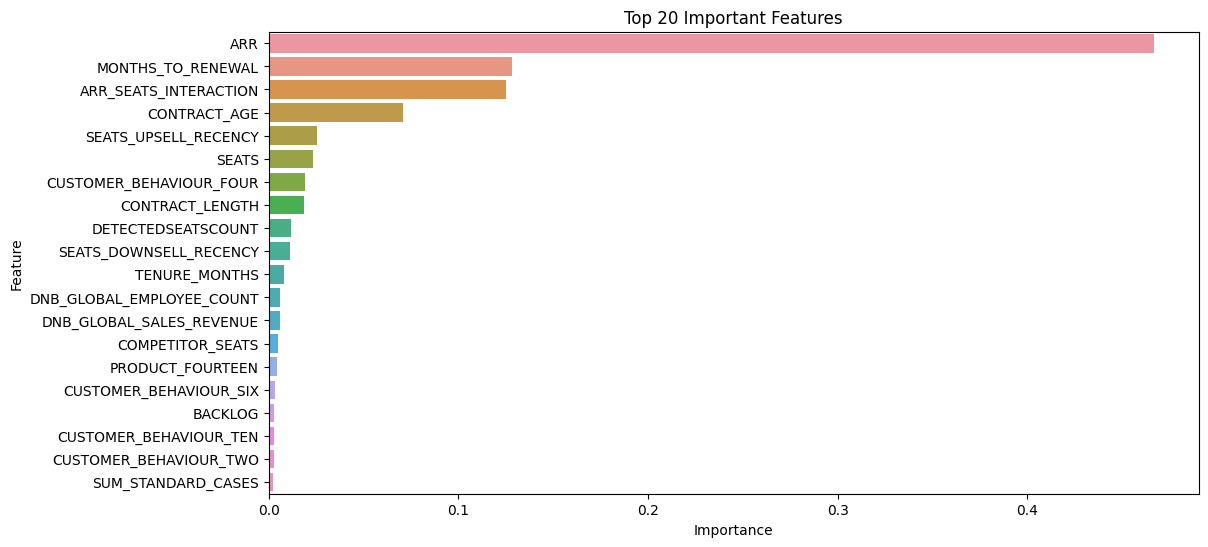

In [113]:
# Extract feature importances from the model
feature_importances = optimal_rf_model.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=features_df.head(20))
plt.title('Top 20 Important Features')
plt.show()

**Feature Importance:** The feature at the top of the chart, `ARR` (Annual Recurring Revenue), is the most important feature, meaning it has the highest influence on the model's output (churn_probability). This is followed by `MONTHS_TO_RENEWAL`, `ARR_SEATS_INTERACTION`, and so on. The importance scores decrease as you move down the chart.
The client can use this information to understand which aspects of their business have the most significant impact on customer churn. For example, if `ARR` is the most important feature, changes in the annual revenue might significantly influence the likelihood of churn. Similarly, `MONTHS_TO_RENEWAL` being a top feature suggests that the time left until a customer's contract renewal is a critical factor in predicting churn. now that we understand the which feature are most influential on predicting ccchurn the client can focus on those areas for intervention.


## Within 12 Month Churn Probability & Risk Score

In [182]:
# Filter the dataset for the relevant period
X_cleaned_filtered = X_cleaned[X_cleaned['MONTHS_TO_RENEWAL'].between(0, 12)]

# Predict churn probabilities for the filtered dataset
X_cleaned_filtered['Churn_Probability'] = optimal_rf_model.predict_proba(X_cleaned_filtered)[:, 1]

# Convert probabilities to risk scores
X_cleaned_filtered['Risk_Score'] = X_cleaned_filtered['Churn_Probability'] * 100
# dataset_without_accountid

X has feature names, but RandomForestClassifier was fitted without feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


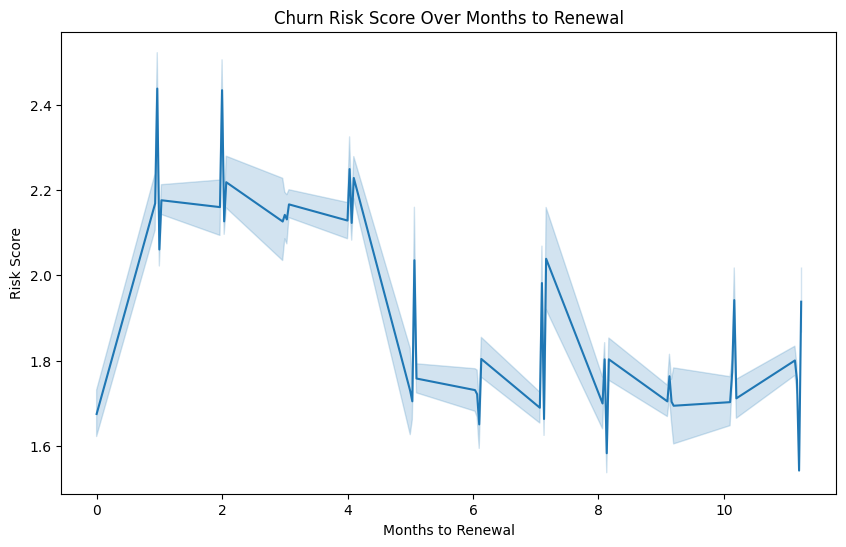

In [110]:
# Visualization of churn risk over months to renewal
plt.figure(figsize=(10, 6))
sns.lineplot(x='MONTHS_TO_RENEWAL', y='Risk_Score', data=X_cleaned_filtered)
plt.title('Churn Risk Score Over Months to Renewal')
plt.xlabel('Months to Renewal')
plt.ylabel('Risk Score')
plt.show()

### Key Observations
- **Risk Score Trend:** The line plot shows the risk score fluctuating over time, with noticeable peaks and troughs. This suggests that the churn risk score for customers varies at different times in the renewal cycle.
- The Risk Score being higher when the "Months to Renewal" is closer to 0 could indicate that the risk of churn increases as customers approach the end of their subscription or contract period. Here are some reasons why this might occur:

- **Decision Point:** As customers near the end of their contract, they are often at a critical decision-making point. This is when they evaluate their experience and decide whether to continue with the service. If they are dissatisfied or if a competitor offers a better option, the risk of churn naturally increases.
- **Competitive Offers:** Competitors might target customers with attractive offers as they near the end of their contracts, hoping to lure them away. Awareness of alternatives can increase churn risk.
- **End-of-Contract Promotions:** Some businesses offer promotions or discounts to new customers or at the beginning of contracts. As the contract progresses and these promotions expire, customers may face higher payments, which can increase churn risk.``

In [118]:
# Merge the risk score and churn probability back into the original dataset
dataset_with_scores = dataset.merge(
    X_cleaned_filtered[['Churn_Probability', 'Risk_Score']],
    left_index=True,
    right_index=True,
    how='left'
)

In [164]:
# Merge the risk score and churn probability back into the original dataset up to 12M
dataset_with_scores_12M = dataset.merge(
    X_cleaned_filtered[['Churn_Probability', 'Risk_Score']],
    left_index=True,
    right_index=True,
    how='inner'
)
# Create the customer_index column
customer_index = range(0, len(dataset_with_scores_12M))

# Insert the customer_index column as the first column in the DataFrame
dataset_with_scores_12M.insert(0, 'customer_index', customer_index)

In [179]:
dataset_with_scores.to_csv('dataset_with_scores.csv')

In [166]:
dataset_with_scores_12M.to_csv('dataset_with_scores_12M.csv')

In [170]:
# Reset the index of the DataFrame
X_cleaned_filtered_v2 = X_cleaned_filtered.reset_index(drop=True)
X_cleaned_filtered_v2

,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,COMPETITOR_SEATS,DETECTEDSEATSCOUNT,PRODUCT_ONE,PRODUCT_TWO,...,SECTOR_Professional Services,SECTOR_Real Estate,SECTOR_Retail & Wholesale,SECTOR_Sci/Tech,SECTOR_Telecommunications,"SECTOR_Transportation, Storage & Delivery","SECTOR_Travel, Hospitality & Catering",SECTOR_nan,Churn_Probability,Risk_Score
0,126.0,55961051.0,260.0,364.0,27241.17,330,0,1.015152,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012917,1.291667
1,127.0,55961051.0,260.0,364.0,27241.17,330,0,1.021212,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012917,1.291667
2,129.0,55961051.0,260.0,364.0,30349.76,350,0,0.960000,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010417,1.041667
3,130.0,55961051.0,260.0,364.0,30349.76,350,0,0.940000,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010417,1.041667
4,131.0,55961051.0,260.0,364.0,30349.76,350,0,0.988571,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007917,0.791667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87214,157.0,420591642.0,5275.0,880.0,18966.39,400,341,0.742500,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.091583,9.158333
87215,158.0,420591642.0,5275.0,323.0,21621.07,400,341,0.735000,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.091583,9.158333
87216,159.0,420591642.0,5275.0,323.0,21621.07,400,0,0.730000,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.081667,8.166667
87217,160.0,420591642.0,5275.0,323.0,21621.07,400,0,0.727500,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.085417,8.541667


In [176]:
import shap

# Initialize SHAP explainer on the Random Forest model
explainer = shap.TreeExplainer(optimal_rf_model)

# Calculate SHAP values for the filtered dataset
shap_values = explainer.shap_values(X_cleaned_filtered_v2)

# Summarize the effects of all the features
# shap.summary_plot(shap_values[1], X_cleaned_filtered_v2, plot_type="bar")


# H

In [190]:
# Create a new DataFrame with rows where Risk_Score is greater than or equal to 4 (this is high risk users)
high_risk_df = X_cleaned_filtered_v2[X_cleaned_filtered_v2['Risk_Score'] >= 3].copy()

# Display the first few rows of the new DataFrame
high_risk_df.head(50)

,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,COMPETITOR_SEATS,DETECTEDSEATSCOUNT,PRODUCT_ONE,PRODUCT_TWO,...,SECTOR_Professional Services,SECTOR_Real Estate,SECTOR_Retail & Wholesale,SECTOR_Sci/Tech,SECTOR_Telecommunications,"SECTOR_Transportation, Storage & Delivery","SECTOR_Travel, Hospitality & Catering",SECTOR_nan,Churn_Probability,Risk_Score
17,39.0,3.615757e+07,480.0,365.0,24869.60,420,293,0.692857,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.032417,3.241667
18,40.0,3.615757e+07,480.0,365.0,24869.60,420,324,0.690476,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.032417,3.241667
77,75.0,5.973866e+08,3500.0,364.0,115653.28,1539,0,0.933723,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065833,6.583333
78,76.0,5.973866e+08,3500.0,364.0,115653.28,1539,1133,0.932424,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080833,8.083333
79,77.0,5.973866e+08,3500.0,364.0,115653.28,1539,0,0.934373,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070833,7.083333
80,78.0,5.973866e+08,3500.0,364.0,115653.28,1539,0,0.936972,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078333,7.833333
81,79.0,5.973866e+08,3500.0,364.0,115653.28,1539,0,0.952567,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070833,7.083333
124,9.0,1.575920e+08,146.0,365.0,1077.20,21,30,1.142857,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032417,3.241667
125,10.0,1.575920e+08,146.0,365.0,1077.20,21,30,1.142857,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032417,3.241667
133,19.0,1.575920e+08,146.0,364.0,1076.83,21,29,1.238095,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034917,3.491667


In [183]:
# For a single prediction
customer_index = 77  # using a high risk customer to find reason for high risk of churning.
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][customer_index], 
    X_cleaned_filtered_v2.iloc[customer_index]
)

The above image is a SHAP force plot, which provides a visual explanation of the contributions of individual features to a specific prediction from our model. The force plot is great for understanding the models predictions at the individual level. Below is the interpretation of the force plot components:

- The **output value** at the center represents the model's prediction for the specific instance. It is calculated by adding the SHAP values of all features to the base value.
- The **base value** is the model's average prediction across the training dataset. It serves as the starting point for adding feature contributions.
- **Red bars** indicate features that are pushing the prediction to a higher value, suggesting an increased likelihood of the event (e.g., customer churn).
- **Blue bars** show features that are pushing the prediction to a lower value, suggesting a decreased likelihood of the event.
- The **length of each bar** signifies the strength of the feature's impact on the prediction. A longer bar denotes a more significant influence.
- Next to the feature names, the **actual values** of these features for the prediction instance are listed.

In the churn prediction model context, if the output value is higher than the base value, it implies a higher likelihood of churn for the particular case. Conversely, a lower output value indicates a lower likelihood of churn.

For instance, in the provided plot:
- Features  like `TENURE_MONTHS`, `SEATS`, and `DNB_GLOBAL_SALES_REVENUE` are contributing to a lower churn probability (negative SHAP values), indicating that higher values of these features are associated with a decreased likelihood of churn.
- Features like `ARR_SEATS_INTERACTION`, `CUSTOMER_BEHAVIOUR_SIX`, and `ARR ` appear in blue, contributing positively to churn likelihood (increasing the risk of churn).

This is how we can determine what will be a likely cause for churn if we neglect it or what we can do to help continue the loyalty that could also help reduce churn.

Based on the SHAP values from the force plot, the customer relations team can take targeted actions to reduce churn:

### Negative SHAP Values (Reducing Churn Probability)
- **CUSTOMER_BEHAVIOUR_NINE**: This customer behavior pattern is showing a correlation with lower churn risk.
  - **Action**: Identify specific behaviors within "CUSTOMER_BEHAVIOUR_NINE" and find ways to encourage these behaviors across your customer base. Consider recognizing and reinforcing these behaviors through positive feedback or rewards.

- **DNB_GLOBAL_EMPLOYEE_COUNT**: A larger employee count seems to be linked to lower churn risk.
  - **Action**: Understand the needs of larger organizations and how your product or service meets these needs effectively. Continue to build features and provide services that support scalability and enterprise-level requirements.

- **CONTRACT_AGE**: The age of the contract is showing a negative correlation with churn, suggesting that customers with longer-standing contracts are less likely to churn.
  - **Action**: For customers with newer contracts, focus on relationship-building and providing a high-quality onboarding experience to increase the likelihood of a long-term relationship. For those with older contracts, maintain high levels of service and consider loyalty rewards to appreciate their long-term commitment.


  

### Positive SHAP Values (Increasing Churn Probability)
- **ARR_SEATS_INTERACTION**: A combination of higher ARR and more seats increases churn risk.
  - **Action**: Review and possibly adjust pricing structures to offer scalable pricing models that reward larger seat commitments.
  
- **CUSTOMER_BEHAVIOUR_SIX**: Certain customer behaviors may be indicative of higher churn risk.
  - **Action**: Investigate and understand these behaviors. Provide targeted support to ensure a positive customer experience.
  
- **ARR (Annual Recurring Revenue)**: Higher ARR may be causing customers to reconsider the value for money.
  - **Action**: Evaluate the value delivered and ensure high-ARR customers are realizing the benefits of their investment. Offer customized value propositions where needed.
